## VGG-16

In [131]:
import copy

import numpy as np
import pandas as pd

import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split

import torch.nn as nn
import torchvision
from torchvision import transforms, models

import matplotlib as plt
import copy

In [41]:
if torch.backends.mps.is_available():
    print("MPS (Metal Performance Shaders) GPU is available.")
else:
    print("No GPU is available.")

MPS (Metal Performance Shaders) GPU is available.


In [81]:
# define transform for train val and test
image_transforms = {
    # training with augmentation
    'train':
        transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(1),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,)) #fashion mnist
        ]),
    'val':
        transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(1),
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ]),
    'test':
        transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(1),
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])
}

fashion_full_train = torchvision.datasets.FashionMNIST('../data', train=True, download=True)
fashion_test = torchvision.datasets.FashionMNIST('../data', train=False, transform=image_transforms['test'], download=True)


In [82]:
print(len(fashion_test))

10000


In [83]:
class_mapping = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

In [84]:

fashion_train, fashion_val = random_split(fashion_full_train, [int(len(fashion_full_train)*0.8), int(len(fashion_full_train)*0.2)])

fashion_train.dataset.transform = image_transforms['train']
fashion_val.dataset.transform = image_transforms['val']


In [85]:
batch_size = 8

train_loader = DataLoader(fashion_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(fashion_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=True)

In [86]:
# Get a single batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Check the structure of the images and labels
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: torch.Size([8, 1, 224, 224])
Labels shape: torch.Size([8])


In [137]:
model_vgg16 = models.vgg16(weights='DEFAULT')

In [138]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [139]:
# modify the first layer of VGG-16 to accept single-channel input
model_vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)

# freeze early layers
for name, param in model_vgg16.named_parameters():
    if "features" in name:
        param.requires_grad = False

In [140]:
n_classes = 10
n_inputs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1))

model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [141]:
# summary(model_vgg16, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

In [142]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
model_vgg16 = model_vgg16.to(device)
# model_vgg16.cuda()

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    # model_vgg16.train()  # do I want to set the model to training? no
    running_loss = 0.0

    # training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # step the scheduler after each epoch
    scheduler.step()

    # validation loop
    # model_vgg16.eval()  # guess no need for setting
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg16(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # average losses and accuracy
    avg_training_loss = running_loss / len(train_loader)
    avg_validation_loss = validation_loss / len(val_loader)
    validation_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_training_loss:.4f}, "
          f"Validation Loss: {avg_validation_loss:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.2f}%")

print('Fine-tuning complete!')

# Save the fine-tuned model
torch.save(model_vgg16.state_dict(), '../vggmodel/finetuned_vgg16_mnist_0.pth')
print('Model saved!')

In [119]:
# Test the model on the test set
model_vgg16.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.7196, Test Accuracy: 72.62%


visualize the loss landscape

In [117]:
import loss_landscapes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Model device: cpu
Input data device: cpu
Labels device: cpu


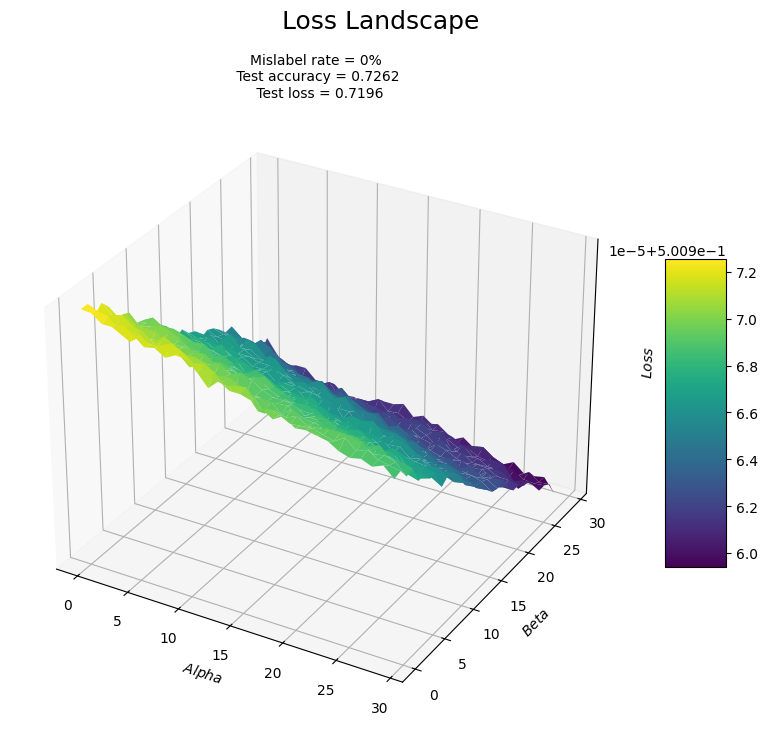

In [121]:
model_vgg16 = model_vgg16.to(device)
model_vgg16.eval()
# Parameters
STEPS = 30
distance = 2e6
loss_fn = nn.CrossEntropyLoss()


# Get a batch of data from the test loader
x, y = iter(test_loader).__next__()
x, y = x.to(device), y.to(device)  # Move data to the correct device


# Move model, input data, and labels to CPU
cpu_device = torch.device("cpu")
model_vgg16 = model_vgg16.to(cpu_device)
x, y = x.to(cpu_device), y.to(cpu_device)

# Print device information for debugging
print(f"Model device: {next(model_vgg16.parameters()).device}")
print(f"Input data device: {x.device}")
print(f"Labels device: {y.device}")

# Define the metric for computing the loss
metric = loss_landscapes.metrics.Loss(loss_fn, x, y)

# Compute the loss landscape
loss_data_fin = loss_landscapes.random_plane(
    model_vgg16, metric, distance, STEPS, normalization='filter', deepcopy_model=True
)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

# Create grid for the surface plot
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])

# Create grid for the surface plot
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])

# Plot the surface
surf = ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# Customize the z-axis
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_zticks([])

# Add labels and title
plt.suptitle("Loss Landscape", y=1, fontsize=18)
plt.title(f"Mislabel rate = {percent}% \n Test accuracy = {test_accuracy:.2f}% \n Test loss = {avg_test_loss:.4f}", fontsize=10)
ax.set_xlabel('$Alpha$', rotation=150)
ax.set_ylabel('$Beta$')
ax.set_zlabel('$Loss$', rotation=60)

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the plot
plt.savefig("../vggimages/vgg00_loss.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

mislabels

In [134]:
def mislabel_data(dataset, mislabel_percent):
    # Create a deep copy of the entire dataset
    new_dataset = copy.deepcopy(dataset)

    # Randomly select indices to mislabel
    num_mislabeled = int(len(dataset) * mislabel_percent / 100)
    mislabeled_indices = np.random.choice(len(dataset), num_mislabeled, replace=False)

    # For each selected index, assign a random incorrect label
    num_classes = len(dataset.classes)
    for idx in mislabeled_indices:
        current_label = new_dataset.targets[idx]
        possible_labels = list(range(num_classes))
        possible_labels.remove(current_label.item())
        new_label = np.random.choice(possible_labels)
        new_dataset.targets[idx] = torch.tensor(new_label)

    return new_dataset

In [136]:

# Mislabel percentages
mislabel_percentages = [10, 25, 50, 75, 90]

# Train models with mislabeled data
for percent in mislabel_percentages:
    print(f"Training with {percent}% mislabeled data...")

    # Create mislabeled dataset
    mislabeled_train = mislabel_data(fashion_full_train, percent)
    mislabeled_train, mislabeled_val = random_split(mislabeled_train, [int(len(mislabeled_train)*0.8), int(len(mislabeled_train)*0.2)])
    mislabeled_train.dataset.transform = image_transforms['train']
    mislabeled_val.dataset.transform = image_transforms['val']

    # Create DataLoader for mislabeled data
    mislabeled_train_loader = DataLoader(mislabeled_train, batch_size=batch_size, shuffle=True)
    mislabeled_val_loader = DataLoader(mislabeled_val, batch_size=batch_size, shuffle=True)

    # Reinitialize the model
    model_vgg16_mislabeled = models.vgg16(weights='DEFAULT')
    for name, param in model_vgg16.named_parameters():
        if "features" in name:
            param.requires_grad = False
    model_vgg16_mislabeled.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    n_inputs = model_vgg16_mislabeled.classifier[6].in_features
    model_vgg16_mislabeled.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 10),  # 10 classes for FashionMNIST
        nn.LogSoftmax(dim=1)
    )
    model_vgg16_mislabeled = model_vgg16_mislabeled.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_vgg16_mislabeled.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        model_vgg16_mislabeled.train()
        running_loss = 0.0

        # Training phase
        for images, labels in mislabeled_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_vgg16_mislabeled(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Validation phase
        model_vgg16_mislabeled.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in mislabeled_val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_vgg16_mislabeled(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average losses and accuracy
        avg_train_loss = running_loss / len(mislabeled_train_loader)
        avg_val_loss = val_loss / len(mislabeled_val_loader)
        val_accuracy = 100 * correct / total

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%")

    # Save the model
    model_name = f"vgg16_mislabel_{percent}percent.pth"
    torch.save(model_vgg16_mislabeled.state_dict(), model_name)
    print(f"Model saved as {model_name}")

    # Evaluate on the test set
    model_vgg16_mislabeled.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg16_mislabeled(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Mislabel Percentage: {percent}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Visualize the loss landscape for this model
    print(f"Visualizing loss landscape for {percent}% mislabeled model...")

    # Move model, input data, and labels to CPU
    cpu_device = torch.device("cpu")
    model_vgg16_mislabeled = model_vgg16_mislabeled.to(cpu_device)
    x, y = x.to(cpu_device), y.to(cpu_device)

    # Print device information for debugging
    print(f"Model device: {next(model_vgg16_mislabeled.parameters()).device}")
    print(f"Input data device: {x.device}")
    print(f"Labels device: {y.device}")

    # Define the metric for computing the loss
    metric = loss_landscapes.metrics.Loss(loss_fn, x, y)

    # Compute the loss landscape
    loss_data_fin = loss_landscapes.random_plane(
        model_vgg16_mislabeled, metric, distance, STEPS, normalization='filter', deepcopy_model=True
    )

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')

    # Create grid for the surface plot
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])

    # Plot the surface
    surf = ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

    # Customize the z-axis
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_zticks([])

    # Add labels and title
    plt.suptitle("Loss Landscape", y=1, fontsize=18)
    plt.title(f"Mislabel rate = {percent}% \n Test accuracy = {test_accuracy:.2f}% \n Test loss = {avg_test_loss:.4f}", fontsize=10)
    ax.set_xlabel('$Alpha$', rotation=150)
    ax.set_ylabel('$Beta$')
    ax.set_zlabel('$Loss$', rotation=60)

    # Add a color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    # Save the plot
    plt.savefig(f"../vggimages/vgg{percent}_loss.pdf", format='pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

Training with 10% mislabeled data...
Epoch [1/10], Train Loss: 1.2496, Validation Loss: 0.9986, Validation Accuracy: 71.34%
Epoch [2/10], Train Loss: 1.1537, Validation Loss: 1.0187, Validation Accuracy: 72.33%
Epoch [3/10], Train Loss: 1.1406, Validation Loss: 0.9638, Validation Accuracy: 72.76%
Epoch [4/10], Train Loss: 1.1285, Validation Loss: 0.9412, Validation Accuracy: 73.71%
Epoch [5/10], Train Loss: 1.1155, Validation Loss: 0.9439, Validation Accuracy: 74.10%


KeyboardInterrupt: 